## Genre classification using TF-IDF and linear models

In [39]:
# Importing all useful packages
import pandas as pd
from pathlib import Path
import re
from sklearn.model_selection import train_test_split
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import joblib
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from datetime import datetime
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

##### Setting up correct paths to save plots in the following three chunks, do not number two or three chunk  unless you need to save models and plots

In [2]:
# Setting up path as the working directory, and ensuring it is correct (Should be /src)
path = Path.cwd()
print(path)

/work/NLP/Exam/NLP-Project-CogSci/src


In [3]:
plot_dir = path.parents[0] / "plots"
plot_dir.mkdir(exist_ok=True)

In [4]:
art_dir = path.parents[0] / "artifacts"
art_dir.mkdir(exist_ok=True)

In [5]:
#Loading in genius lyrics data from kaggle: https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information/data
#To properly run these scripts on other machines, the data must be locally downloaded and it's path referred to by data_path
data_path = path.parents[2] / "exam_data" / "song_lyrics.csv"
raw_genius_lyrics = pd.read_csv(data_path)


In [6]:
#Sanity check for if data fits online description of dataset
print(raw_genius_lyrics.head())
print(raw_genius_lyrics.info())

               title  tag     artist  year   views  \
0          Killa Cam  rap    Cam'ron  2004  173166   
1         Can I Live  rap      JAY-Z  1996  468624   
2  Forgive Me Father  rap   Fabolous  2003    4743   
3       Down and Out  rap    Cam'ron  2004  144404   
4             Fly In  rap  Lil Wayne  2005   78271   

                                       features  \
0                   {"Cam\\'ron","Opera Steve"}   
1                                            {}   
2                                            {}   
3  {"Cam\\'ron","Kanye West","Syleena Johnson"}   
4                                            {}   

                                              lyrics  id language_cld3  \
0  [Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...   1            en   
1  [Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...   3            en   
2  Maybe cause I'm eatin\nAnd these bastards fien...   4            en   
3  [Produced by Kanye West and Brian Miller]\n\n[...   5            en  

In [7]:
#Similar sanity check for the columns of the dataset
data_columns = raw_genius_lyrics.columns.tolist()
print(data_columns)

['title', 'tag', 'artist', 'year', 'views', 'features', 'lyrics', 'id', 'language_cld3', 'language_ft', 'language']


In [8]:
#Checking the most popular genres and what percentage of the data they constitute
print(raw_genius_lyrics["tag"].value_counts().head(10))
print(raw_genius_lyrics["tag"].value_counts(normalize=True) * 100)


tag
pop        2138587
rap        1724816
rock        793220
rb          196462
misc        181455
country     100316
Name: count, dtype: int64
tag
pop        41.648432
rap        33.590348
rock       15.447755
rb          3.826047
misc        3.533789
country     1.953628
Name: proportion, dtype: float64


Given the largy disparity in the distribution of genres, i should keep this in mind so that a Naive classifier doesn't just score 42 % by guessing pop on everything. Look up some solutions for this that seem worthwhile

In [9]:
#Checking the most prevalent languages and what percentage of the data they constitute
print(raw_genius_lyrics["language"].value_counts().head(10))
print(raw_genius_lyrics["language"].value_counts(normalize=True) * 100)


language
en    3374198
es     275432
fr     189436
pt     167947
ru     166044
de     160150
it     118775
pl      83862
tr      44692
ja      42637
Name: count, dtype: int64
language
en    68.749809
es     5.611970
fr     3.859788
pt     3.421946
ru     3.383172
        ...    
mt     0.000102
uz     0.000082
tg     0.000061
bs     0.000020
gu     0.000020
Name: proportion, Length: 84, dtype: float64


In [10]:
lyrics_processed = raw_genius_lyrics.copy()

lyrics_processed = lyrics_processed[lyrics_processed["language"] == "en"]

lyrics_processed = lyrics_processed.reset_index(drop=True)

lyrics_processed["language"].value_counts().head()
print("Rows after English filter:", len(lyrics_processed))

Rows after English filter: 3374198


In [11]:
print(lyrics_processed["language"].value_counts().head(10))
print(lyrics_processed["language"].value_counts(normalize=True) * 100)

language
en    3374198
Name: count, dtype: int64
language
en    100.0
Name: proportion, dtype: float64


In [12]:
#Checking the most popular genres and what percentage of the data they constitute after filtering for english
lyrics_processed["tag"].value_counts().head(10)
lyrics_processed["tag"].value_counts(normalize=True) * 100


tag
pop        41.300451
rap        28.587682
rock       18.769142
rb          4.596114
misc        4.178356
country     2.568255
Name: proportion, dtype: float64

In [13]:
#To optimise the time for the remainder of the preprocessing pipeline and eventual analysis, we create a copy of the data only including the relevant columns
data_short = lyrics_processed[["lyrics", "tag"]].copy()

#Drop missing values and ensure all lyrics are strings
data_short = data_short.dropna(subset=["lyrics"])

data_short["lyrics"] = data_short["lyrics"].astype(str)

# empty or whitespace-only
data_short = data_short[data_short["lyrics"].str.strip().ne("")]

# remove duplicates (exact)
data_short = data_short.drop_duplicates(subset=["lyrics"])
data_short = data_short.reset_index(drop=True)

In [14]:
BRACKET_TAG_RE = re.compile(r"\[.*?\]")  # removes anything in [ ... ]
WS_RE = re.compile(r"\s+")

def normalize_lyrics(text: str) -> str:
    s = str(text)

    # Normalize unicode
    s = unicodedata.normalize("NFKC", s)

    # Normalize apostrophes
    s = s.replace("’", "'").replace("‘", "'")

    # Convert backslash-n sequences into real newlines
    s = s.replace("\\r\\n", "\n").replace("\\n", "\n").replace("\\r", "\n")

    # Remove bracketed metadata
    s = BRACKET_TAG_RE.sub(" ", s)

    # Lowercase
    s = s.lower()

    # Collapse all whitespace (spaces, tabs, newlines) to single spaces
    s = WS_RE.sub(" ", s).strip()

    return s

data_short["lyrics_norm"] = data_short["lyrics"].map(normalize_lyrics)

data_short[["lyrics", "lyrics_norm"]].head(3)

,lyrics,lyrics_norm
0,"[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...","killa cam, killa cam, cam killa cam, killa cam..."
1,"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...","yeah, hah, yeah, roc-a-fella we invite you to ..."
2,Maybe cause I'm eatin\nAnd these bastards fien...,maybe cause i'm eatin and these bastards fiend...


In [15]:
X = data_short["lyrics_norm"]
y = data_short["tag"]

# 80% train, 20% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.2,
    random_state=558,
    stratify=y
)

# split temp into 10% val, 10% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=558,
    stratify=y_temp
)

In [16]:
tfidf = TfidfVectorizer(
    stop_words="english",   
    ngram_range=(1, 2),     # unigrams + bigrams often helps
    min_df=5,               
    max_df=0.9,             
    max_features=200000    
)

Xtr = tfidf.fit_transform(X_train)
Xva = tfidf.transform(X_val)
Xte = tfidf.transform(X_test)

In [17]:
len(tfidf.vocabulary_)

200000

In [18]:
clf = LogisticRegression(
    max_iter=200,
    class_weight="balanced"
)

clf.fit(Xtr, y_train)

/work/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [19]:
val_pred = clf.predict(Xva)
print(classification_report(y_val, val_pred, digits=3))

              precision    recall  f1-score   support

     country      0.179     0.692     0.284      8592
        misc      0.409     0.711     0.519     13603
         pop      0.682     0.323     0.438    135104
         rap      0.896     0.781     0.834     96223
          rb      0.199     0.606     0.300     15424
        rock      0.450     0.575     0.505     62678

    accuracy                          0.542    331624
   macro avg      0.469     0.614     0.480    331624
weighted avg      0.653     0.542     0.559    331624



In [20]:
clfimp = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

clfimp.fit(Xtr, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [21]:
val_pred = clfimp.predict(Xva)
print(classification_report(y_val, val_pred, digits=3))

              precision    recall  f1-score   support

     country      0.192     0.654     0.296      8592
        misc      0.434     0.692     0.533     13603
         pop      0.681     0.365     0.475    135104
         rap      0.896     0.790     0.840     96223
          rb      0.206     0.582     0.304     15424
        rock      0.451     0.573     0.505     62678

    accuracy                          0.559    331624
   macro avg      0.476     0.609     0.492    331624
weighted avg      0.655     0.559     0.576    331624



Given the very long time to converge using a logistic regression model, even with the limit for tf-idf features, it seems like i should move to a more computationally efficient method. I can consider raising the feature cap of tf-idf but that would only slow the model training. I will try a linear model before doing anything further

In [22]:
clflin = LinearSVC(class_weight="balanced")

clflin.fit(Xtr, y_train)

,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'squared_hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive.For an intuitive visualization of the effects of scalingthe regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"multi_class multi_class: {'ovr', 'crammer_singer'}, default='ovr'Determines the multi-class strategy if `y` contains more thantwo classes.``""ovr""`` trains n_classes one-vs-rest classifiers, while``""crammer_singer""`` optimizes a joint objective over all classes.While `crammer_singer` is interesting from a theoretical perspectiveas it is consistent, it is seldom used in practice as it rarely leadsto better accuracy and is more expensive to compute.If ``""crammer_singer""`` is chosen, the options loss, penalty and dualwill be ignored.",'ovr'
,"fit_intercept fit_intercept: bool, default=TrueWhether or not to fit an intercept. If set to True, the feature vectoris extended to include an intercept term: `[x_1, ..., x_n, 1]`, where1 corresponds to the intercept. If set to False, no intercept will beused in calculations (i.e. data is expected to be already centered).",True
,"intercept_scaling intercept_scaling: float, default=1.0When `fit_intercept` is True, the instance vector x becomes ``[x_1,..., x_n, intercept_scaling]``, i.e. a ""synthetic"" feature with aconstant value equal to `intercept_scaling` is appended to the instancevector. The intercept becomes intercept_scaling * synthetic featureweight. Note that liblinear internally penalizes the intercept,treating it like any other term in the feature vector. To reduce theimpact of the regularization on the intercept, the `intercept_scaling`parameter can be set to a value greater than 1; the higher the value of`intercept_scaling`, the lower the impact of regularization on it.Then, the weights become `[w_x_1, ..., w_x_n,w_intercept*intercept_scaling]`, where `w_x_1, ..., w_x_n` representthe feature weights and the intercept weight is scaled by`intercept_scaling`. This scaling allows the intercept term to have adifferent regularization behavior compared to the other features.",1
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to ``class_weight[i]*C`` forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: int, default=0Enable verbose output. Note that this setting takes advantage of aper-process runtime setting in liblinear that, if enabled, may not workproperly in a multithreaded context.",0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseud

In [23]:
lin_val_pred = clflin.predict(Xva)
print(classification_report(y_val, lin_val_pred, digits=3))

              precision    recall  f1-score   support

     country      0.234     0.499     0.319      8592
        misc      0.485     0.645     0.554     13603
         pop      0.653     0.562     0.604    135104
         rap      0.864     0.841     0.852     96223
          rb      0.235     0.398     0.296     15424
        rock      0.472     0.447     0.459     62678

    accuracy                          0.615    331624
   macro avg      0.491     0.565     0.514    331624
weighted avg      0.643     0.615     0.625    331624



In [24]:
clfsdg = SGDClassifier(
    loss="log_loss",
    class_weight="balanced",
    max_iter=1000,
    tol=1e-3
)

clfsdg.fit(Xtr, y_train)

,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'log_loss'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",1000
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [25]:
sdg_val_pred = clfsdg.predict(Xva)
print(classification_report(y_val, sdg_val_pred, digits=3))

              precision    recall  f1-score   support

     country      0.274     0.343     0.305      8592
        misc      0.526     0.585     0.554     13603
         pop      0.605     0.711     0.654    135104
         rap      0.842     0.814     0.828     96223
          rb      0.255     0.293     0.272     15424
        rock      0.516     0.296     0.376     62678

    accuracy                          0.628    331624
   macro avg      0.503     0.507     0.498    331624
weighted avg      0.628     0.628     0.621    331624



In [26]:
#Summarizing and comparing across models

def summarize(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "macro_f1": f1_score(y_true, y_pred, average="macro"),
        "weighted_f1": f1_score(y_true, y_pred, average="weighted"),
        "macro_precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "macro_recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
    }

models = {
    "LogReg": clfimp,
    "LinearSVC": clflin,
    "SGD(log_loss)": clfsdg
}

rows = []
for name, model in models.items():
    pred_val = model.predict(Xva)
    rows.append({"model": name, **summarize(y_val, pred_val)})

results_val = (
    pd.DataFrame(rows)
      .sort_values("macro_f1", ascending=False)
      .reset_index(drop=True)
)
display(results_val)

,model,accuracy,macro_f1,weighted_f1,macro_precision,macro_recall
0,LinearSVC,0.615209,0.513993,0.624904,0.490703,0.565246
1,SGD(log_loss),0.628459,0.498103,0.620836,0.502772,0.507044
2,LogReg,0.558708,0.492228,0.576404,0.476455,0.609445


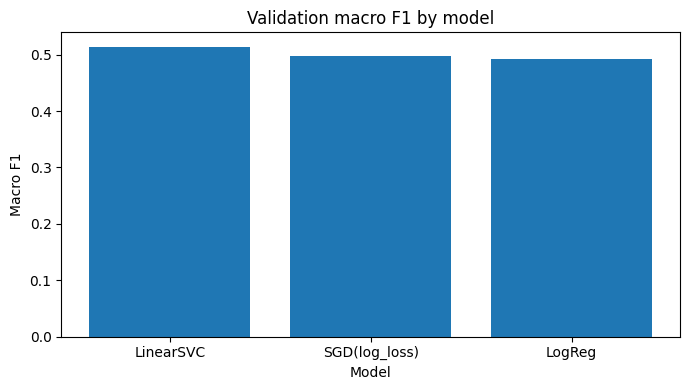

In [28]:
#Saving plot of model comparison

fig, ax = plt.subplots(figsize=(7, 4))
ax.bar(results_val["model"], results_val["macro_f1"])
ax.set_title("Validation macro F1 by model")
ax.set_xlabel("Model")
ax.set_ylabel("Macro F1")
plt.tight_layout()

plt.show()

fig.savefig(plot_dir / "model_comparison_macro_f1_val.png", dpi=300, bbox_inches="tight")
plt.close(fig)

results_val.to_csv(art_dir / "model_comparison_val.csv", index=False)

In [30]:
table_df = results_val.copy()

table_df = table_df.rename(columns={
    "model": "Model",
    "accuracy": "Accuracy",
    "macro_f1": "Macro F1",
    "weighted_f1": "Weighted F1",
    "macro_precision": "Macro Precision",
    "macro_recall": "Macro Recall",
})

table_df[[
    "Accuracy",
    "Macro F1",
    "Weighted F1",
    "Macro Precision",
    "Macro Recall"
]] = table_df[[
    "Accuracy",
    "Macro F1",
    "Weighted F1",
    "Macro Precision",
    "Macro Recall"
]].round(3)

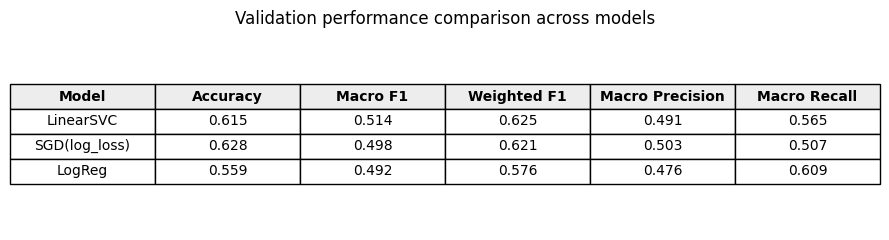

In [ ]:
fig, ax = plt.subplots(figsize=(9, 2.5))
ax.axis("off")

tbl = ax.table(
    cellText=table_df.values,
    colLabels=table_df.columns,
    loc="center",
    cellLoc="center"
)

# Styling
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

# Bold header row
for (row, col), cell in tbl.get_celld().items():
    if row == 0:
        cell.set_text_props(weight="bold")
        cell.set_facecolor("#EDEDED")

ax.set_title("Validation performance comparison across models", pad=10)

plt.tight_layout()
fig.savefig(
    plot_dir / "model_comparison_val_table.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()
plt.close(fig)


##### Given the comparison between models, we choose the macro f1 as our evaluation metric for which model to proceed with

In [32]:
best_model = clflin
test_pred = best_model.predict(Xte)

cm = confusion_matrix(y_test, test_pred, labels=best_model.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(ax=ax, xticks_rotation=90, values_format="d", colorbar=False)
ax.set_title("Confusion matrix (test)")
plt.tight_layout()
fig.savefig(plot_dir / "confusion_matrix_test.png", dpi=300)
plt.close(fig)

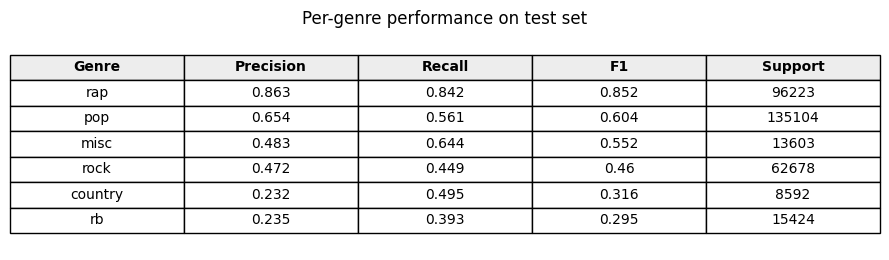

In [36]:
rep = classification_report(y_test, test_pred, output_dict=True, zero_division=0)
rep_df = pd.DataFrame(rep).T
rep_df.to_csv(art_dir / "classification_report_test.csv", index=True)

per_class = rep_df.drop(index=["accuracy", "macro avg", "weighted avg"], errors="ignore")
table_df = per_class[["precision", "recall", "f1-score", "support"]].copy()
table_df.index.name = "Genre"

table_df[["precision", "recall", "f1-score"]] = table_df[["precision", "recall", "f1-score"]].round(3)
table_df["support"] = table_df["support"].astype(int)

table_df = table_df.sort_values("f1-score", ascending=False)

table_df.to_csv(art_dir / "per_genre_metrics_test.csv")

fig, ax = plt.subplots(figsize=(9, 2.7))
ax.axis("off")

tbl = ax.table(
    cellText=table_df.reset_index().values,
    colLabels=["Genre", "Precision", "Recall", "F1", "Support"],
    loc="center",
    cellLoc="center"
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

for (r, c), cell in tbl.get_celld().items():
    if r == 0:
        cell.set_text_props(weight="bold")
        cell.set_facecolor("#EDEDED")

ax.set_title("Per-genre performance on test set", pad=10)

plt.tight_layout()
fig.savefig(plot_dir / "per_genre_metrics_test_table.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

Final plots used in report, and saving the the LinearSVC model

In [37]:
s = data_short["tag"].value_counts()
pct = (s / s.sum() * 100).sort_values(ascending=True)  # ascending for nicer horizontal plot

fig, ax = plt.subplots(figsize=(9, 6))
bars = ax.barh(pct.index, pct.values)

ax.set_title(f"Genre distribution (n={s.sum():,})")
ax.set_xlabel("Percentage of songs (%)")
ax.set_ylabel("Genre")

# Add labels at the end of each bar
for b in bars:
    w = b.get_width()
    ax.text(
        w + 0.3,                       # small offset to the right
        b.get_y() + b.get_height()/2,
        f"{w:.1f}%",
        va="center"
    )

# Give a bit of breathing room for labels
ax.set_xlim(0, pct.max() * 1.15)

plt.tight_layout()
fig.savefig(plot_dir / "genre_distribution_percent.png", dpi=300, bbox_inches="tight")
plt.close(fig)

In [40]:
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")

final_pipe = Pipeline([
    ("tfidf", tfidf),
    ("model", best_model),
])

joblib.dump(final_pipe, art_dir / f"final_model_pipeline_{run_id}.joblib")

['/work/NLP/Exam/NLP-Project-CogSci/artifacts/final_model_pipeline_20260205_234955.joblib']